# Basic Distributed Usage

In [1]:
# set number of cpu devices for jax pmap
import os

num_devices = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={num_devices}"

import jax
import jax.numpy as jnp
from flax import jax_utils

print(jax.devices())

from evosax.problems import BBOBFitness
from evosax.v2 import SNES

fn_name = "Sphere"
num_dims = 2
population_size = 32
rng = jax.random.key(0)
evaluator = BBOBFitness(fn_name, num_dims=num_dims, n_devices=num_devices)

strategy = SNES(
    population_size=population_size,
    num_dims=num_dims,
    sigma_init=0.1,
    n_devices=num_devices,
    maximize=False,
)

es_params = strategy.default_params.replace(init_min=-3.0, init_max=3.0)
es_params = jax_utils.replicate(es_params)

init_rng = jnp.tile(rng[None], (num_devices, 1))
es_state = jax.pmap(strategy.init)(init_rng, es_params)
print("Mean pre-update:", es_state.mean)  # (num_devices, num_dims)

rng, rng_a, rng_e = jax.random.split(rng, 3)
ask_rng = jax.random.split(rng_a, num_devices)
x, es_state = jax.pmap(strategy.ask, axis_name="device")(ask_rng, es_state, es_params)

print(
    "Population shape:", x.shape
)  # (num_devices, population_size/num_devices, num_dims)

fitness = evaluator.rollout(rng_e, x)
print("Fitness shape:", fitness.shape)  # (num_devices, population_size/num_devices)

es_state = jax.pmap(strategy.tell, axis_name="device")(x, fitness, es_state, es_params)
print("Mean post-update:", es_state.mean)  # (num_devices, num_dims)

I0000 00:00:1729595240.070905       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Mean pre-update: [[-1.7022278  1.8247447]
 [-1.7022278  1.8247447]
 [-1.7022278  1.8247447]
 [-1.7022278  1.8247447]]
Population shape: (4, 8, 2)
Fitness shape: (4, 8)
Mean post-update: [[-1.6293062  1.7537518]
 [-1.6293062  1.7537518]
 [-1.6293062  1.7537518]
 [-1.6293062  1.7537518]]


# Running the distributed API in a loop!

In [2]:
from evosax.v2 import DistributedStrategies


def run_strategy_eval(
    strategy_name, num_dims, population_size, num_generations, fn_name
):
    rng = jax.random.key(0)
    evaluator = BBOBFitness(fn_name, num_dims=num_dims, n_devices=num_devices)

    strategy = DistributedStrategies[strategy_name](
        population_size=population_size,
        num_dims=num_dims,
        sigma_init=0.1,
        n_devices=num_devices,
        maximize=False,
    )
    es_params = strategy.default_params.replace(init_min=-3.0, init_max=3.0)
    es_params = jax_utils.replicate(es_params)

    init_rng = jnp.tile(rng[None], (num_devices, 1))
    es_state = jax.pmap(strategy.init)(init_rng, es_params)
    log = []
    for i in range(num_generations):
        rng, rng_a, rng_e = jax.random.split(rng, 3)
        ask_rng = jax.random.split(rng_a, num_devices)
        x, es_state = jax.pmap(strategy.ask, axis_name="device")(
            ask_rng, es_state, es_params
        )
        fitness = evaluator.rollout(rng_e, x)
        es_state = jax.pmap(strategy.tell, axis_name="device")(
            x, fitness, es_state, es_params
        )
        if (i + 1) % 5 == 0:
            print(
                f"{strategy_name} -> Gen {i + 1}: Mean fitness:", fitness.mean()
            )  # (num_devices, num_dims)
        log.append(fitness.mean())
    return log

In [11]:
num_dims = 2
population_size = 32
num_generations = 20
fn_name = "Sphere"
snes_log = run_strategy_eval(
    "SNES", num_dims, population_size, num_generations, fn_name
)
sep_cma_es_log = run_strategy_eval(
    "Sep_CMA_ES", num_dims, population_size, num_generations, fn_name
)
openes_log = run_strategy_eval(
    "OpenES", num_dims, population_size, num_generations, fn_name
)
pgpe_log = run_strategy_eval(
    "PGPE", num_dims, population_size, num_generations, fn_name
)

SNES -> Gen 5: Mean fitness: 4.2919803
SNES -> Gen 10: Mean fitness: 1.6909255
SNES -> Gen 15: Mean fitness: 0.21123376
SNES -> Gen 20: Mean fitness: 0.034145456
Sep_CMA_ES -> Gen 5: Mean fitness: 3.8235738
Sep_CMA_ES -> Gen 10: Mean fitness: 2.3550215
Sep_CMA_ES -> Gen 15: Mean fitness: 0.41724688
Sep_CMA_ES -> Gen 20: Mean fitness: 0.039137628
OpenES -> Gen 5: Mean fitness: 4.9614086
OpenES -> Gen 10: Mean fitness: 3.5875664
OpenES -> Gen 15: Mean fitness: 2.43984
OpenES -> Gen 20: Mean fitness: 1.5216942
PGPE -> Gen 5: Mean fitness: 2.8394666
PGPE -> Gen 10: Mean fitness: 0.531984
PGPE -> Gen 15: Mean fitness: 0.048206907
PGPE -> Gen 20: Mean fitness: 0.74076486


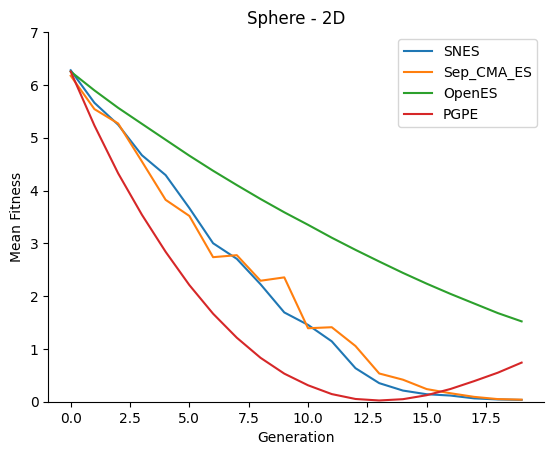

In [15]:
import matplotlib.pyplot as plt

plt.plot(snes_log, label="SNES")
plt.plot(sep_cma_es_log, label="Sep_CMA_ES")
plt.plot(openes_log, label="OpenES")
plt.plot(pgpe_log, label="PGPE")
plt.xlabel("Generation")
plt.ylabel("Mean Fitness")
plt.title(f"{fn_name} - {num_dims}D")
plt.ylim(0, 7)
plt.legend()
# no spines top/right
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)